# Comparying ASC speed in U and XY grids

In order to do a point-by-point comparisson of the ASC speed and the heat transport, we need to interpolate the ASC speed to the grid points on the faces of the grid cell. This itnerpolation was done, so now I will compare how the ASC speed in different grids look like.

For clarification, an representation of the rpevious and new grid below

In [1]:
#     Original grid                    #     Regridded Speed
#      where o=u,v                     #        where o=u,v,Ty  
#                                      #
#   ______Ty______o                    #   ______o______   
#  |              |                    #  |              | 
#  |              |                    #  |              |
#  |      x      Tx                    #  |      x       +   where +=u,v,Tx  
#  |              |                    #  |              |
#  |______________|                    #  |______________|
#                                      #
#  x=T,rho...                          #  x=T,rho...  

In [2]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
import numpy as np
import os
from dask.distributed import Client
# Optional modules
import xgcm
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [3]:
client = Client() 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41013,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:45009,Total threads: 4
Dashboard: /proxy/34115/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:33551,


In [4]:
import cosima_cookbook as cc
session = cc.database.create_session()

#### Importing ASC speed on XY original grid

In [5]:
#importing [Monthly] ASC speed from year 2095 to 2098
import glob
src = '/g/data/x77/wf4500/ASC_project/ASC_speed/monthly/OM2_RYF/Antarctic_slope_contour_1km_velocities_209'
gl =glob.glob(src + "****_uv.nc")
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
##importing data from ocean.nc
Along_slope_v=xr.open_mfdataset(gl, concat_dim='time', combine='nested').mean('time')
Along_slope_v_time=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

48 netcdf data files


In [6]:
%%time
#First fixing the time dimension
experiment = '01deg_jra55v13_ryf9091'
variable = 'time'
start_time='2095-01-01'
end_time='2098-12-31'

timedim = cc.querying.getvar(experiment, 'time', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
timedim = timedim.isel(time=slice(4,100,2)) #Only 2080 and 2081
Along_slope_v_time['time']=timedim.time

CPU times: user 33.6 s, sys: 13.2 s, total: 46.9 s
Wall time: 1min 40s


#### Importing ASC speed on u grid (Regridded)

I still dont have the daily speeds in the same years, so I will use the years I have as a comparisson ( it shouldnt be that differente since this is RYF

In [7]:
for n in range(4):
    ny=n+5
    src = '/g/data/x77/wf4500/ASC_project/ASC_speed/monthly/OM2_RYF_XYgrid/Antarctic_slope_contour_1km_velocities_209'+str(ny)
    gl =glob.glob(src + "****_uv.nc")
    gl=sorted(gl)
    print("%i netcdf data files"%len(gl))
    Along_slope_v_ug0=xr.open_mfdataset(gl, concat_dim='time', combine='nested').mean('time')
    Along_slope_v_time_ug0=xr.open_mfdataset(gl, concat_dim='time', combine='nested')
    
    if n==0:
        Along_slope_v_time_ug=Along_slope_v_time_ug0
    else:
        Along_slope_v_time_ug=xr.concat((Along_slope_v_time_ug,Along_slope_v_time_ug0), 'time')
    
Along_slope_v_ug=Along_slope_v_time_ug.mean('time')

12 netcdf data files
12 netcdf data files
12 netcdf data files
12 netcdf data files


In [8]:
Along_slope_v_time_ug['time']=timedim.time

### Spatial comparisson

How does the ASC speed changes compares spatially between the grid?

In [9]:
#calculating STDs for the whole 2 years
Along_slope_v_time_std = Along_slope_v_time.u_along_contour.std(dim='time')
Along_slope_v_time_ug_std = Along_slope_v_time_ug.u_along_contour.std(dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


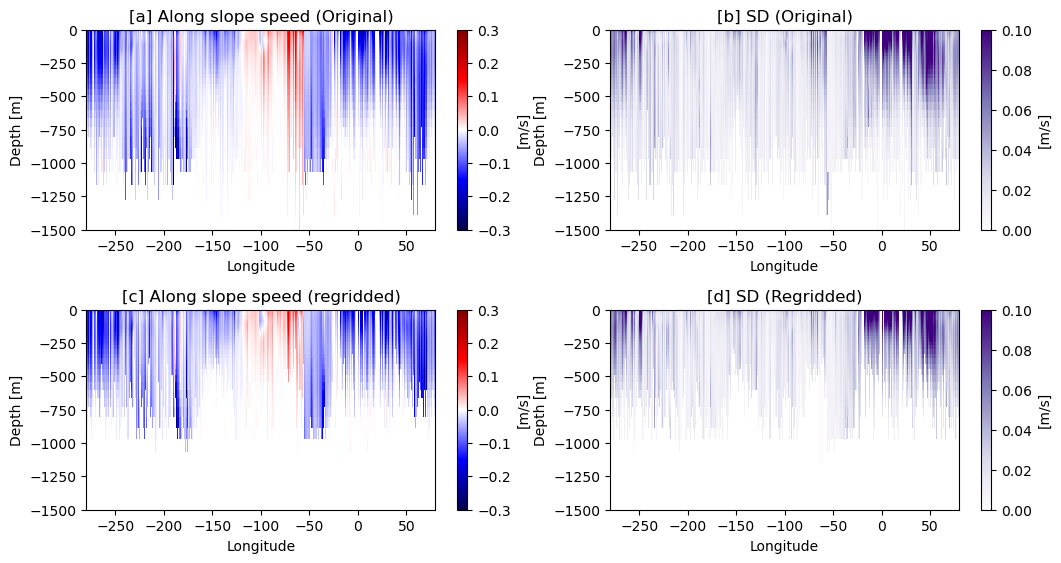

In [10]:
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)



plt.subplot(2,2,1)
plt.pcolormesh(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(0,-1)),-Along_slope_v.st_ocean,
         Along_slope_v.u_along_contour.isel(distance_along_contour=slice(0,-1)),vmin=-0.3, vmax=0.3,cmap='seismic')

plt.ylim(-1500,0)
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.colorbar(label='[m/s]')
plt.title('[a] Along slope speed (Original)')

plt.subplot(2,2,2)
plt.pcolormesh(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(0,-1)),-Along_slope_v.st_ocean,
         Along_slope_v_time_std.isel(distance_along_contour=slice(0,-1)),vmin=0, vmax=0.1,cmap='Purples')
plt.ylim(-1500,0)
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.title('[b] SD (Original)')
plt.colorbar(label='[m/s]')



plt.subplot(2,2,3)
plt.pcolormesh(Along_slope_v_ug.lon_along_contour.isel(distance_along_contour=slice(0,-1)),-Along_slope_v_ug.st_ocean,
         Along_slope_v_ug.u_along_contour.isel(distance_along_contour=slice(0,-1)),vmin=-0.3, vmax=0.3,cmap='seismic')

plt.ylim(-1500,0)
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.colorbar(label='[m/s]')
plt.title('[c] Along slope speed (regridded)')


plt.subplot(2,2,4)
plt.pcolormesh(Along_slope_v_ug.lon_along_contour.isel(distance_along_contour=slice(0,-1)),-Along_slope_v_ug.st_ocean,
         Along_slope_v_time_ug_std.isel(distance_along_contour=slice(0,-1)),vmin=0, vmax=0.1,cmap='Purples')
plt.ylim(-1500,0)
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.title('[d] SD (Regridded)')
plt.colorbar(label='[m/s]')

The surface ASC variability along the contour is similar in both grids. The regridded data don't have speeds and deeped cells tho (~1000m), but that is because the target contour created on the XY grid is made in a way to not allow points deeper thatn 1000m.

### Time comparisson

For a time comparisson Ill need to integrate the speed along depth. Ill need cell volumes for that

In [11]:
#Original grid
dzt = cc.querying.getvar(experiment, 'dzt', session, n=1).isel(time=0)
dzt_along_contour = dzt.sel(xt_ocean=Along_slope_v.lon_along_contour,yt_ocean=Along_slope_v.lat_along_contour,method='nearest')

tarea = cc.querying.getvar(experiment, 'tarea', session, n=1) #area_t
tarea = tarea.rename(nx='xt_ocean',ny='yt_ocean')
tarea['xt_ocean']=dzt.xt_ocean
tarea['yt_ocean']=dzt.yt_ocean
tarea_along_contour = tarea.sel(xt_ocean=Along_slope_v.lon_along_contour,yt_ocean=Along_slope_v.lat_along_contour,method='nearest')

In [12]:
#Reggrided ASC
dzt_along_contour_ug = dzt.sel(xt_ocean=Along_slope_v_ug.lon_along_contour,yt_ocean=Along_slope_v_ug.lat_along_contour,method='nearest')

tarea = cc.querying.getvar(experiment, 'tarea', session, n=1) #area_t
tarea = tarea.rename(nx='xt_ocean',ny='yt_ocean')
tarea['xt_ocean']=dzt.xt_ocean
tarea['yt_ocean']=dzt.yt_ocean
tarea_along_contour_ug = tarea.sel(xt_ocean=Along_slope_v_ug.lon_along_contour,yt_ocean=Along_slope_v_ug.lat_along_contour,method='nearest')

Volumes will be

In [13]:
# First calculating the volume to use as a weight
vol_along_contour=tarea_along_contour*dzt_along_contour
vol_along_contour_ug=tarea_along_contour_ug*dzt_along_contour_ug




THe circumpolar ASC  speed will be:

In [14]:
#first month is 
ASC_u = np.nansum(Along_slope_v_time.u_along_contour.isel(time=0)*vol_along_contour)/np.nansum(vol_along_contour)
ASC_u_ug = np.nansum(Along_slope_v_time_ug.u_along_contour.isel(time=0)*vol_along_contour_ug)/np.nansum(vol_along_contour_ug)



for n in np.arange(1,48):
    ASC_u0=Along_slope_v_time.u_along_contour.isel(time=n)
    ASC_u1=np.nansum(ASC_u0*vol_along_contour)/np.nansum(vol_along_contour)
    ASC_u = np.append(ASC_u,ASC_u1)
    
    ASC_u0_ug=Along_slope_v_time_ug.u_along_contour.isel(time=n)
    ASC_u1_ug=np.nansum(ASC_u0_ug*vol_along_contour_ug)/np.nansum(vol_along_contour_ug)
    ASC_u_ug = np.append(ASC_u_ug,ASC_u1_ug)

Circumpolar ASC speed comparisson between grids

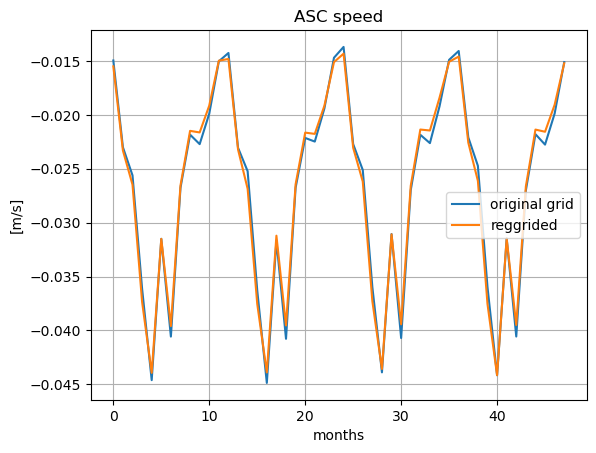

In [15]:
plt.plot(ASC_u,label='original grid')
plt.plot(ASC_u_ug,label='reggrided')
plt.title('ASC speed'); plt.xlabel('months');plt.ylabel('[m/s]')
plt.grid()
plt.legend()